In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import balanced_accuracy_score
from sentence_transformers import SentenceTransformer

/var/git/genai-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/synthetic_normal_2_labeled.csv")
df["label"] = df["label"].astype(int)

model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    device="cuda"
)

X = model.encode(
    df["sentence"].tolist(),
    batch_size=256,
    normalize_embeddings=True,
    convert_to_numpy=True,
    show_progress_bar=True
)

y = df["label"].to_numpy()

np.save("X.npy", X)
np.save("y.npy", y)

Batches: 100%|██████████| 250/250 [00:16<00:00, 15.48it/s]


In [3]:
X = np.load("X.npy")
y = np.load("y.npy")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "features": torch.tensor(self.features[idx], dtype=torch.float32),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class SimpleNN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x): return self.net(x)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleNN(X.shape[1]).to(device)

In [5]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [6]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        features = batch["features"].to(device)
        labels = batch["labels"].to(device)

        logits = model(features).squeeze(-1)
        loss = criterion(logits, labels.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size

        preds = (logits > 0).long()
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

    avg_loss = total_loss / total_samples if total_samples else 0.0
    accuracy = total_correct / total_samples if total_samples else 0.0
    return avg_loss, accuracy


def evaluate(model, dataloader, device="cpu"):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            labels = batch["labels"].to(device)

            logits = model(features).squeeze(-1)
            loss = criterion(logits, labels.float())

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            preds = (logits > 0).long()
            total_correct += (preds == labels).sum().item()
            total_samples += batch_size

    avg_loss = total_loss / total_samples if total_samples else 0.0
    accuracy = total_correct / total_samples if total_samples else 0.0
    return avg_loss, accuracy


def collect_predictions(model, dataloader, device="cpu", threshold=0.5):
    model.eval()
    all_probs = []
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            labels = batch["labels"].to(device)

            logits = model(features).squeeze(-1)
            probs_pos = torch.sigmoid(logits)
            preds = (probs_pos >= threshold).long()

            all_probs.append(probs_pos.cpu())
            all_targets.append(labels.cpu())
            all_preds.append(preds.cpu())

    probs = torch.cat(all_probs) if all_probs else torch.tensor([])
    targets = torch.cat(all_targets) if all_targets else torch.tensor([], dtype=torch.long)
    preds = torch.cat(all_preds) if all_preds else torch.tensor([], dtype=torch.long)
    return targets, probs, preds


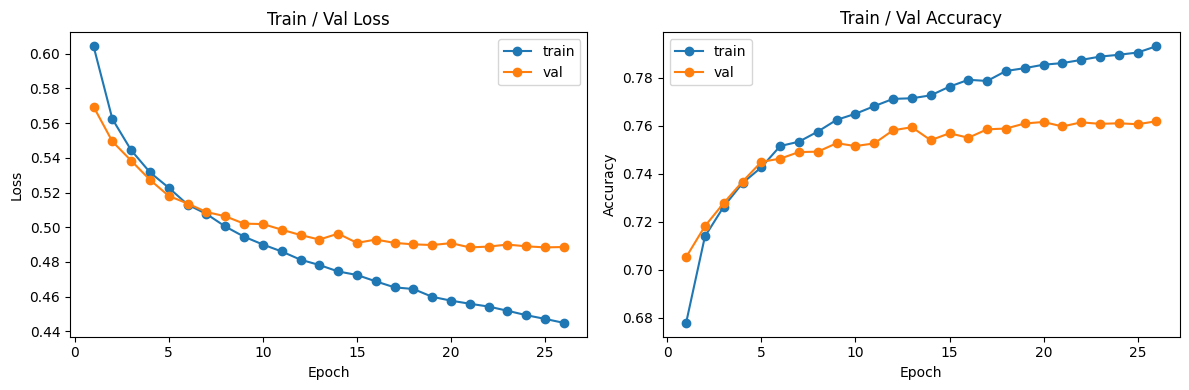

Epoch 26/50 - train_loss: 0.4449, val_loss: 0.4886, train_acc: 0.7932, val_acc: 0.7619
Early stopping at epoch 26 (patience=5)


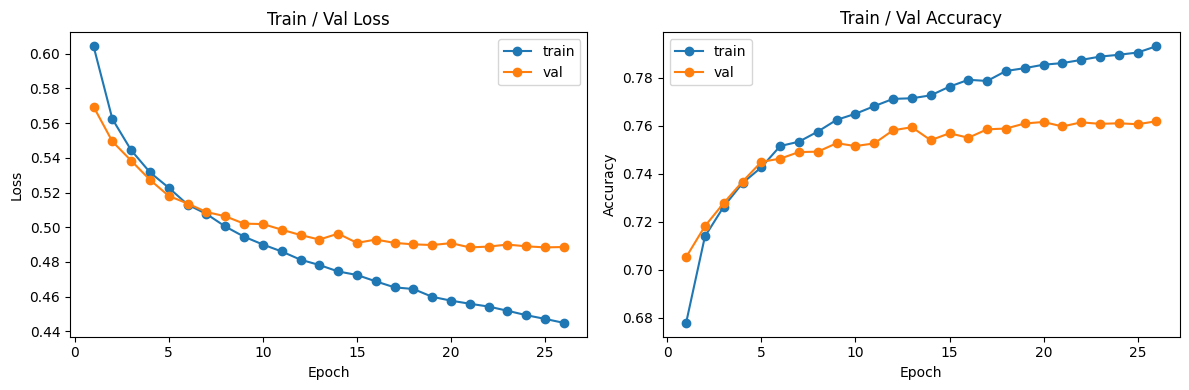

In [7]:
torch.manual_seed(42)
np.random.seed(42)

num_epochs = 50
patience = 5
min_delta = 1e-4
best_val_loss = float("inf")
epochs_no_improve = 0
best_state = None

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def plot_live(fig, axes, epochs_ran, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist):
    axes[0].clear()
    axes[1].clear()

    axes[0].plot(epochs_ran, train_loss_hist, marker="o", label="train")
    axes[0].plot(epochs_ran, val_loss_hist, marker="o", label="val")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Train / Val Loss")
    axes[0].legend()

    axes[1].plot(epochs_ran, train_acc_hist, marker="o", label="train")
    axes[1].plot(epochs_ran, val_acc_hist, marker="o", label="val")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Train / Val Accuracy")
    axes[1].legend()

    plt.tight_layout()
    display(fig)

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, opt, device)
    val_loss, val_acc = evaluate(model, test_loader, device=device)

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    improved = val_loss + min_delta < best_val_loss
    if improved:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        epochs_no_improve += 1

    clear_output(wait=True)
    epochs_ran = range(1, len(train_loss_hist) + 1)
    plot_live(fig, axes, epochs_ran, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist)

    log_line = (
        f"Epoch {epoch + 1}/{num_epochs} "
        f"- train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, "
        f"train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}"
    )
    print(log_line)

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch + 1} (patience={patience})")
        break

if best_state is not None:
    model.load_state_dict(best_state)


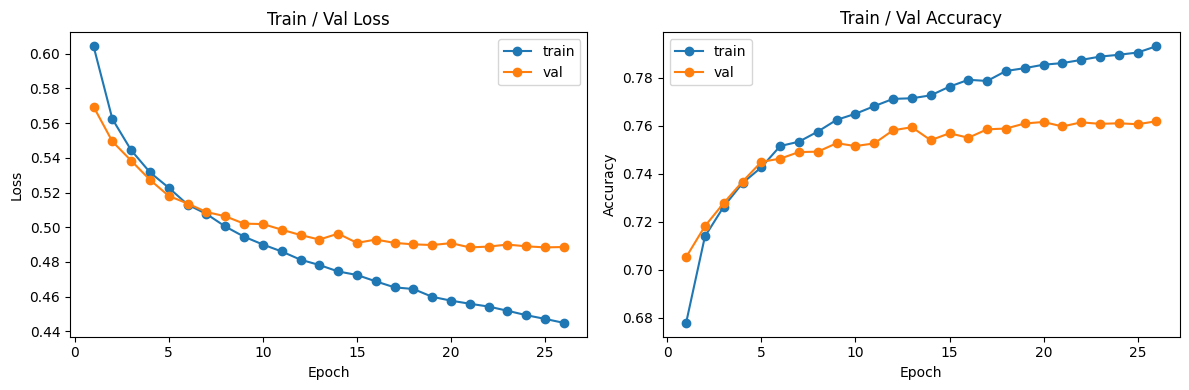

In [8]:
plt.figure(figsize=(12, 4))
epochs_ran = range(1, len(train_loss_hist) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_loss_hist, marker="o", label="train")
plt.plot(epochs_ran, val_loss_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_ran, train_acc_hist, marker="o", label="train")
plt.plot(epochs_ran, val_acc_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train / Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Loss/accuracy
val_loss, val_acc = evaluate(model, test_loader, device=device)

print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}")
val_targets, val_probs, val_preds = collect_predictions(model, test_loader, device)
val_targets_np = val_targets.numpy()
val_preds_np = val_preds.numpy()

print('Precision:', precision_score(val_targets_np, val_preds_np))
print('Recall:', recall_score(val_targets_np, val_preds_np))
print('F1 (binary):', f1_score(val_targets_np, val_preds_np))
print('F1 (macro):', f1_score(val_targets_np, val_preds_np, average="macro"))
print('Balanced accuracy:', balanced_accuracy_score(val_targets_np, val_preds_np))


Test Loss: 0.4884, Test Accuracy: 0.7597
Precision: 0.7566145752746403
Recall: 0.7658574784651527
F1 (binary): 0.7612079701120797
F1 (macro): 0.7597214003436679
Balanced accuracy: 0.7597301176786917
